In [49]:
%pylab inline

import pandas as pd
import numpy as np
import seaborn as sns



Populating the interactive namespace from numpy and matplotlib


In [56]:
import os
import pymysql
import sqlalchemy
import tempfile
import hashlib

def query(sql):
    base_dir = os.path.join(tempfile.gettempdir(), 'yelp')
    hash_key = hashlib.sha1(sql.encode('utf-8')).hexdigest()
    file_path = os.path.join(base_dir, hash_key + '.csv')
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
        
    if os.path.exists(file_path):
        data = pd.read_csv(file_path, index_col=0)
    else:
        engine = sqlalchemy.create_engine('mysql+pymysql://anderson@localhost:3306/yelp')
        data = pd.read_sql(sql, con=engine)
        data.to_csv(file_path)
    return data

In [30]:
# Initialize Stanford f
from nltk.tag.stanford import StanfordNERTagger

base = '/home/anderson/apps/stanford-ner-2018-10-16'
gz = [os.path.join(base, 'classifiers/english.all.3class.distsim.crf.ser.gz'),
      os.path.join(base, 'stanford-ner.jar')]
tagger = StanfordNERTagger(*gz)

# EDA

## 랭킹 - 대중적이면서 스타 등급이 높은 호텔

In [320]:
sql = '''
select business_id,
       name,
       city,
       state,
       latitude,
       longitude,
       stars,
       review_count,
       is_open,
       pow(stars, 1.5) * pow(review_count, 0.6) as rank2

from business
order by rank2
  DESC
limit 10;'''

df = query(sql)
# df.sort_values('stars', ascending=False)
df

,business_id,name,city,state,latitude,longitude,stars,review_count,is_open,rank2
0,WYw3Uf56DT5IwpaLNnCH5Q,vdara hotel & spa at aria las vegas,Las Vegas,NV,36.109301,-115.178147,4.0,2543,1,883.685651
1,na4Th5DrNauOv-c43QQFvA,bellagio hotel,Las Vegas,NV,36.112629,-115.176706,3.5,3187,1,828.192522
2,EAwh1OmG6t6p3nRaZOW_AA,"ellis island hotel, casino & brewery",Las Vegas,NV,36.112996,-115.163396,4.0,2190,1,807.897857
3,El4FC8jcawUVgw_0EIcbaQ,mgm grand hotel,Las Vegas,NV,36.102251,-115.169968,3.0,3944,1,746.868299
4,bsrj9_hFAql3dlSf244zpg,trump international hotel las vegas,Las Vegas,NV,36.129559,-115.172825,4.0,1842,1,728.221945
5,VyjyHoBg3KC5BSFRlD0ZPQ,caesars palace las vegas hotel & casino,Las Vegas,NV,36.116765,-115.174595,3.0,2834,1,612.522138
6,AV6weBrZFFBfRGCbcRGO4g,luxor hotel and casino las vegas,Las Vegas,NV,36.097341,-115.176339,2.5,4117,1,582.986547
7,ii8sAGBexBOJoYRFafF9XQ,paris las vegas hotel & casino,Las Vegas,NV,36.112358,-115.170221,3.0,2513,1,569.898318
8,p0iEUamJVp_QpaheE-Nz_g,"south point hotel, casino & spa",Las Vegas,NV,36.011357,-115.175775,3.5,1613,1,550.405401
9,eEnNw3_hBvxcFHyr23kAuA,hard rock hotel & casino,Las Vegas,NV,36.109230,-115.154036,3.0,2277,1,537.155096


## Counting useful, cool, funny

,count(*),useful,funny,cool,useful_pct,funny_pct,cool_pct,all_pct
0,6685900,3115446.0,1373727.0,1672612.0,0.466,0.2055,0.2502,0.5256


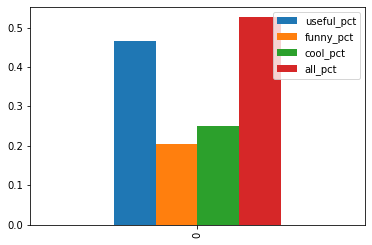

In [69]:
sql = '''
select count(*),
       sum(case when useful > 0 then 1 else 0 end)                                     useful,
       sum(case when funny > 0 then 1 else 0 end)                                      funny,
       sum(case when cool > 0 then 1 else 0 end)                                       cool,
       sum(case when useful > 0 then 1 else 0 end) / count(*)                          useful_pct,
       sum(case when funny > 0 then 1 else 0 end) / count(*)                           funny_pct,
       sum(case when cool > 0 then 1 else 0 end) / count(*)                            cool_pct,
       sum(case when useful > 0 or funny > 0 or cool > 0 then 1 else 0 end) / count(*) all_pct
from review;'''
df = query(sql)
display(df)
df.plot(y=['useful_pct', 'funny_pct', 'cool_pct', 'all_pct'], kind='bar')

## 비즈니스 stars 와 댓글과의 관계

In [322]:
sql = '''
select cast(b.stars as int)                                                            business_star,
       avg(b.rank)                                                                     rank_avg,
       avg(pow(b.stars, 1.5) * pow(b.review_count, 0.6))                               rank2_avg,
       avg(b.review_count)                                                             avg_review_count,
       avg(r.stars)                                                                    avg_star_rv,
       avg(r.useful)                                                                   avg_useful_rv,
       avg(r.funny)                                                                    avg_funny_rv,
       avg(r.cool)                                                                     avg_cool_rv,
       avg(r.useful + r.funny + r.cool)                                                avg_ufc,
       avg(r.funny + r.cool)                                                           avg_fc,
       sum(case when r.useful > 0 then 1 else 0 end)                                   useful_cnt,
       sum(case when r.funny > 0 then 1 else 0 end)                                    funny_cnt,
       sum(case when r.cool > 0 then 1 else 0 end)                                     cool_cnt,
       sum(case when useful > 0 or funny > 0 or cool > 0 then 1 else 0 end)            all_cnt,
       sum(case when r.useful > 0 then 1 else 0 end) / count(*)                        useful_pct,
       sum(case when r.funny > 0 then 1 else 0 end) / count(*)                         funny_pct,
       sum(case when r.cool > 0 then 1 else 0 end) / count(*)                          cool_pct,
       sum(case when useful > 0 or funny > 0 or cool > 0 then 1 else 0 end) / count(*) all_pct
from review r
       join business b on b.business_id = r.business_id
group by cast(b.stars as int)'''
df = query(sql)
df

,business_star,rank_avg,rank2_avg,avg_review_count,avg_star_rv,avg_useful_rv,avg_funny_rv,avg_cool_rv,avg_ufc,avg_fc,useful_cnt,funny_cnt,cool_cnt,all_cnt,useful_pct,funny_pct,cool_pct,all_pct
0,1,13.007984,4.334563,13.0080,1.105788,1.319361,0.491018,0.187625,1.998004,0.678643,275.0,105.0,59.0,294.0,0.5489,0.2096,0.1178,0.5868
1,2,4527.769615,312.126780,1812.5871,2.449194,1.457780,0.705221,0.516566,2.679567,1.221787,19594.0,10902.0,8714.0,22204.0,0.5052,0.2811,0.2247,0.5725
2,3,4600.572258,366.099649,1533.5241,3.017583,1.539018,0.688427,0.655944,2.883389,1.344371,16511.0,8788.0,8270.0,18621.0,0.5212,0.2774,0.2611,0.5878
3,4,3115.266878,332.062776,826.9159,3.789379,1.437758,0.572550,0.672859,2.683166,1.245409,21515.0,10071.0,11741.0,24044.0,0.5040,0.2359,0.2750,0.5632
4,5,216.652299,95.678638,43.3305,4.875000,1.326149,0.293103,0.550287,2.169540,0.843391,335.0,95.0,171.0,364.0,0.4813,0.1365,0.2457,0.5230


In [323]:
df = df[df['business_star'] < 5]

,business_star,rank_avg,rank2_avg,avg_review_count,avg_star_rv,avg_useful_rv,avg_funny_rv,avg_cool_rv,avg_ufc,avg_fc,useful_cnt,funny_cnt,cool_cnt,all_cnt,useful_pct,funny_pct,cool_pct,all_pct
rank2_avg,0.798422,0.947615,1.000000,0.840330,0.884871,0.922246,0.807810,0.971510,0.991291,0.998592,0.948030,0.952756,0.932007,0.949006,-0.873653,0.801796,0.969288,-0.431366
avg_fc,0.782705,0.954096,0.998592,0.848957,0.868807,0.941438,0.822593,0.966743,0.996878,1.000000,0.930168,0.939099,0.912201,0.931433,-0.848208,0.818083,0.961722,-0.382914
avg_ufc,0.753202,0.959842,0.991291,0.859310,0.838963,0.965123,0.842226,0.953739,1.000000,0.996878,0.899008,0.914649,0.877617,0.900739,-0.806602,0.839946,0.944628,-0.308800
avg_cool_rv,0.915506,0.846511,0.971510,0.688273,0.962620,0.867487,0.649809,1.000000,0.953739,0.966743,0.926252,0.895795,0.950401,0.924353,-0.839571,0.643982,0.998533,-0.481788
cool_pct,0.921942,0.839969,0.969288,0.682652,0.971009,0.845227,0.638150,0.998533,0.944628,0.961722,0.941366,0.908254,0.965577,0.939305,-0.863731,0.630752,1.000000,-0.528219
funny_cnt,0.719667,0.924152,0.952756,0.857498,0.834899,0.792213,0.799338,0.895795,0.914649,0.939099,0.988216,1.000000,0.949503,0.990017,-0.971339,0.785494,0.908254,-0.616143
all_cnt,0.801475,0.875596,0.949006,0.779344,0.897103,0.758228,0.713059,0.924353,0.900739,0.931433,0.999925,0.990017,0.983710,1.000000,-0.981534,0.698114,0.939305,-0.683802
useful_cnt,0.808061,0.870763,0.948030,0.771936,0.901847,0.755032,0.705077,0.926252,0.899008,0.930168,1.000000,0.988216,0.985794,0.999925,-0.981339,0.690071,0.941366,-0.688558
rank_avg,0.564281,1.000000,0.947615,0.967967,0.691710,0.935482,0.953487,0.846511,0.959842,0.954096,0.870763,0.924152,0.803739,0.875596,-0.808379,0.949678,0.839969,-0.269776
cool_cnt,0.893113,0.803739,0.932007,0.668228,0.959031,0.723257,0.597985,0.950401,0.877617,0.912201,0.985794,0.949503,1.000000,0.983710,-0.956694,0.583338,0.965577,-0.718612


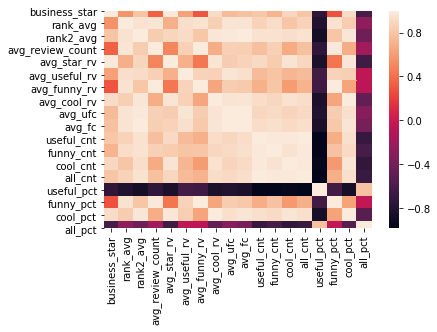

In [324]:
corr = df.corr()
corr = corr.reindex(corr['rank2_avg'].abs().sort_values(ascending=False).index)
display(corr)
sns.heatmap(df.corr())

## Word Cloud for Category

In [150]:
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords = set(stopwords.words('english')) | set(STOPWORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/anderson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


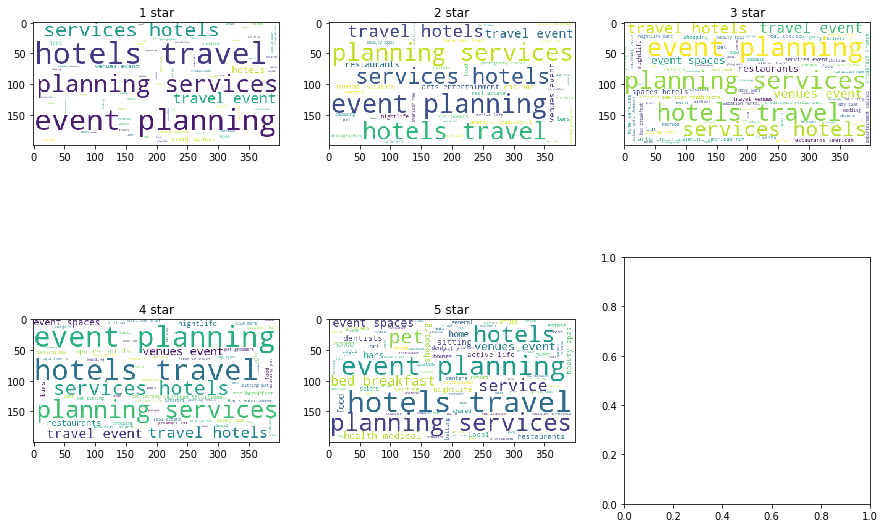

In [307]:
sql = '''select * from business'''
df = query(sql)
df['stars'] = df['stars'].astype('int')

fig, plots = subplots(2, 3, figsize=(15, 10))
plots = plots.reshape(-1)
for i in range(5):
    star_df = df[df['stars'] == i+1]
    string = star_df['categories'].str.cat(sep=' ')
    wordcloud = WordCloud(background_color="white").generate(string)
    plots[i].imshow(wordcloud)
    plots[i].set_title(f'{i+1} star')